Example notebook trying to emulate FindLCsFromOpSim.ipynb which seems to be corrupted

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os
import sqlite3

In [2]:
from lsst.sims.catUtils.mixins import CosmologyMixin
from lsst.sims.utils import ObservationMetaData
from lsst.sims.catUtils.utils import ObservationMetaDataGenerator
from lsst.sims.catalogs.generation.db import CatalogDBObject
from lsst.sims.catalogs.measures.instance import InstanceCatalog
import eups

/usr/local/manual/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)
Duplicate object type id 25 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
Duplicate object type id 40 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
Duplicate object type id 40 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
Duplicate object type id 40 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
Duplicate object type id 40 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want

In [3]:
from lsst.sims.catUtils.mixins import SNIaCatalog
from lsst.sims.catUtils.mixins import SNObject


In [4]:
def samplePatchOnSphere(phi, theta, delta, size):
    '''
    (not) Uniformly distributes samples on a spherical patch between phi \pm delta,
    and theta \pm delta.
    
    will modify to fix this later
    Parameters
    ----------
    phi: float, mandatory, radians
        center of the spherical patch in ra with range 
    theta: float, mandatory, radians
    delta: float, mandatory, radians
    size: int, mandatory
        number of samples
    '''
    u = np.random.uniform(size=size)
    v = np.random.uniform(size=size)

    # phivals = delta * (2. * u - 1) + phi
    phivals = 2. * delta* u + (phi - delta )
    phivals = np.where ( phivals >= 0., phivals, phivals + 2. * np.pi)
    
    # use conventions in spherical coordinates
    theta = np.pi/2.0 - theta
    # thetavals = 2. * delta* v + (theta - delta )
    # thetavals = np.where ( thetavals < np.pi , thetavals, thetavals - np.pi)
    # thetavals = np.where ( thetavals > - np.pi , thetavals, thetavals + np.pi)
    
    
    thetamax = theta + delta
    thetamin = theta - delta
    # CDF is cos(thetamin) - cos(theta) / cos(thetamin) - cos(thetamax)
    a = np.cos(thetamin) - np.cos(thetamax)
    thetavals = np.arccos(-v * a + np.cos(thetamin))
    # Get back to -pi/2 to pi/2 range of decs
    thetavals = np.pi/2.0 - thetavals 
    return phivals, thetavals

In [5]:
def cleanDB(dbname, verbose=True):
    '''
    Deletes the database dbname from the disk.
    Parameters
    ----------
    dbname: string, mandatory
        name (abs path) of the database to be deleted
    verbose: Bool, optional, defaults to True

    '''

    if os.path.exists(dbname):
        if verbose:
            print "deleting database ", dbname
        os.unlink(dbname)
    else:
        if verbose:
            print 'database ', dbname, ' does not exist'
            

In [6]:
def sample_obsmetadata(obsmetadata, size=1):
    '''
    Sample a square patch on the sphere overlapping obsmetadata
    field of view by picking the area enclosed in
    obsmetadata.unrefractedRA \pm obsmetadata.boundLength
    obsmetadata.unrefractedDec \pm obsmetadata.boundLength

    Parameters
    ----------
    obsmetadata: instance of
        `sims.catalogs.generation.db.ObservationMetaData`

    size: integer, optional, defaults to 1
        number of samples


    Returns
    -------

    tuple of ravals, decvalues
    '''
    mydict = obsmetadata.summary
    phi = np.radians(mydict['pointingRA'])
    theta = np.radians(mydict['pointingDec'])
    equalrange = np.radians(mydict['boundLength'])
    ravals, thetavals = samplePatchOnSphere(phi=phi, theta=theta, delta=equalrange, size=size)
    return ravals, thetavals

In [7]:
def _createFakeGalaxyDB(dbname, ObsMetaData, size=10000, seed=1):
    '''
    Create a local sqlite galaxy database having filename dbname with variables
    id, raJ2000, decJ2000 and redshift, having number of rows =size, and having
    overlap with ObsMetaData.
    '''
    cleanDB(dbname)
    conn = sqlite3.connect(dbname)
    curs = conn.cursor()
    curs.execute('CREATE TABLE if not exists gals (id INT, raJ2000 FLOAT,\
                  decJ2000 FLOAT, redshift FLOAT)')

    np.random.seed(seed)
    samps = sample_obsmetadata(ObsMetaData, size=size)

    for count in range(size):
        id = 1000000 + count

        # Main Database should have values in degrees
        ra = np.degrees(samps[0][count])
        dec = np.degrees(samps[1][count])
        redshift = np.random.uniform()
        row = tuple([id, ra, dec, redshift])
        exec_str = insertfromdata(tablename='gals', records=row,
                                     multiple=False)
        curs.execute(exec_str, row)

    conn.commit()
    conn.close()
    return samps

In [8]:
def insertfromdata(tablename, records, multiple=True):
    """
    construct string to insert multiple records into sqlite3 database
    args:
        tablename: str, mandatory
            Name of table in the database.
        records: set of records
        multiple:
    returns:
    """
    if multiple:
        lst = records[0]
    else:
        lst = records
    s = 'INSERT INTO ' + str(tablename) + ' VALUES '
    s += "( " + ", ".join(["?"]*len(lst)) + ")"
    return s

In [9]:
class myGalaxyCatalog(CatalogDBObject):
    '''
    Create a like CatalogDBObject connecting to a local sqlite database
    '''

    objid = 'mytestgals'
    tableid = 'gals'
    idColKey = 'id'
    objectTypeId = 0
    appendint = 10000
    database = 'testdata/galcat.db'
    # dbAddress = './testData/galcat.db'
    raColName = 'raJ2000'
    decColName = 'decJ2000'
    driver = 'sqlite'

    # columns required to convert the ra, dec values in degrees
    # to radians again
    columns = [('id', 'id', int),
               ('raJ2000','raJ2000 * PI()/ 180. '),
               ('decJ2000','decJ2000 * PI()/ 180.'),
               ('redshift', 'redshift')]

## Now create a fake galaxy table

In [10]:
obsMetaDataforCat = ObservationMetaData(boundType='circle',
                                          boundLength=np.degrees(0.25),
                                          pointingRA=np.degrees(0.13),
                                          pointingDec=np.degrees(-1.2),
                                          bandpassName=['r'],
                                          mjd=49350.)

In [11]:
sample_obsmetadata(obsMetaDataforCat, size=1)

(array([ 6.19125244]), array([-1.16569371]))

In [12]:
obsMetaDataforCat.boundLength

14.323944878270581

In [13]:
obsMetaDataforCat._boundLength

0.25

In [14]:
if not os.path.exists('testSNData'):
    os.makedirs('testSNData')
testdbName = 'testSNData/galcat.db'
vals = _createFakeGalaxyDB(dbname=testdbName,
                    ObsMetaData=obsMetaDataforCat,
                    size=1000000,
                    seed=1)

deleting database  testSNData/galcat.db


In [15]:
vals

(array([ 0.088511  ,  0.24016225,  6.16324249, ...,  0.12661688,
         6.21759016,  0.06512591]),
 array([-0.99399571, -1.21610453, -1.15133414, ..., -1.02888506,
        -1.33583417, -1.04711557]))

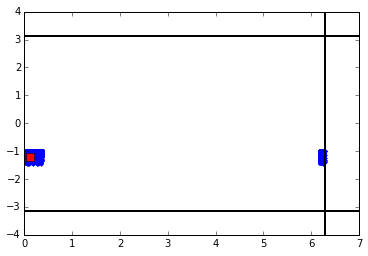

In [16]:

plt.plot(vals[0][:1000], vals[1][:1000], '.')
plt.axvline(2. * np.pi, color='k', lw=2.)
plt.axvline(0., color='k', lw=2.)
plt.axhline(np.pi, color='k', lw=2.)
plt.axhline(-np.pi, color='k', lw=2.)
plt.plot([0.13], [-1.2], 'rs', markersize=8)

In [17]:
galDB = myGalaxyCatalog(database=testdbName)

In [18]:
class galCopy(InstanceCatalog):
    column_outputs = ['id', 'raJ2000', 'decJ2000', 'redshift']
    override_formats = {'raJ2000': '%8e', 'decJ2000': '%8e'}

In [19]:
galphot = galCopy(db_obj=galDB, obs_metadata=obsMetaDataforCat)


In [20]:
galphot.write_catalog('gals.dat')

In [21]:
!wc -l gals.dat

  743976 gals.dat


In [22]:
!head gals.dat

#id, raJ2000, decJ2000, redshift
1000000, 8.851100e-02, -9.939957e-01, 0.0376
1000001, 2.401622e-01, -1.216105e+00, 0.7608
1000003, 3.116629e-02, -1.009110e+00, 0.1566
1000007, 5.278036e-02, -9.771580e-01, 0.3991
1000008, 7.838374e-02, -1.024724e+00, 0.7685
1000009, 1.494084e-01, -9.881543e-01, 0.9084
1000010, 8.959726e-02, -1.070042e+00, 0.5480
1000011, 2.226098e-01, -1.132653e+00, 0.8986
1000013, 3.190587e-01, -1.084762e+00, 0.0921


## Building Light Curves from Instance Catalogs


We would like to create a number of supernova instance catalogs and then build the light curves from the catalogs. To do this correctly, we would like to use the observation_metadata associated with a number of conscutive OpSIM pointings.

In [23]:
opsimPath = os.path.join(eups.productDir('sims_data'),'OpSimData')
opsimDB = os.path.join(opsimPath,'opsimblitz1_1133_sqlite.db')

# from Tuscon AHM notebook from Scott
# This OPSIM DB is provided in sims_data. This creates a list of opsim pointings
# that I have checked. This is a tuned notebook
generator = ObservationMetaDataGenerator() #database = opsimPath, driver='sqlite')
obsMetaDataResults = generator.getObservationMetaData(limit=100,
                                                      fieldRA=(5.0, 8.0), 
                                                      fieldDec=(-85.,-60.),
                                                      expMJD=(49300., 49400.),
                                                      boundLength=0.015,
                                                      boundType='circle')


In [24]:
# How many pointings do we have? 
print (len(obsMetaDataResults))

15


In [25]:
def coords(x):
    return np.radians(x.summary['pointingRA']), np.radians(x.summary['pointingDec'])
   

In [26]:
v = zip(*map(coords, obsMetaDataResults))

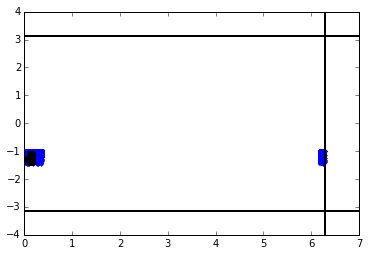

In [27]:
plt.plot(v[0], v[1], 'ko', markersize=4)
plt.plot(vals[0][:1000], vals[1][:1000], '.')
plt.axvline(2. * np.pi, color='k', lw=2.)
plt.axvline(0., color='k', lw=2.)
plt.axhline(np.pi, color='k', lw=2.)
plt.axhline(-np.pi, color='k', lw=2.)
plt.plot(v[0], v[1], 'ko', markersize=8)

In [28]:
if not os.path.exists('testSNData/NewLightCurves'): 
    os.makedirs('testSNdata/NewLightCurves')

In [29]:
column_outputs=['flux_u', 'flux_g', 'flux_r', 'flux_i', 'flux_z', 'flux_y',
                'mag_u', 'mag_g', 'mag_r', 'mag_i', 'mag_z', 'mag_y']

In [30]:
catalog = SNIaCatalog(db_obj=galDB, 
                            obs_metadata=obsMetaDataResults[0], 
                            column_outputs=['t0', 'flux_u', 'flux_g', 'flux_r', 'flux_i', 'flux_z',
                                            'flux_y', 'mag_u', 'mag_g', 'mag_r', 'mag_i', 
                                            'mag_z', 'mag_y', 'adu_u', 'adu_g', 'adu_r',
                                            'adu_i', 'adu_z', 'adu_y','mwebv'])

In [31]:
catalog.midSurveyTime=catalog.mjdobs - 20.


In [32]:
catalog.snFrequency

2.7397260273972603e-05

In [33]:
print (catalog.mjdobs)

49362.070248


In [34]:
print (catalog.maxTimeSNVisible)

100.0


In [35]:
catalog.write_catalog('testSNData/NewLightCurves/FullCatalog.dat')

/Users/rbiswas/src/LSST/sims_catutils/python/lsst/sims/catUtils/mixins/snObject.py:657: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(f)


In [36]:
!cat testSNData/NewLightCurves/FullCatalog.dat

#snid, snra, sndec, z, t0, c, x1, x0, flux_u, flux_g, flux_r, flux_i, flux_z, flux_y, mag_u, mag_g, mag_r, mag_i, mag_z, mag_y, adu_u, adu_g, adu_r, adu_i, adu_z, adu_y, mwebv


In [37]:
newcatalog = SNIaCatalog(db_obj=galDB, 
                         obs_metadata=obsMetaDataResults[0], 
                         column_outputs=['t0', 'time', 'band', 'flux', 'flux_err', 'mag', 'mag_err', 'mwebv'])

In [38]:
newcatalog.averageRate = 600.

In [39]:
newcatalog.averageRate

600.0

In [40]:
newcatalog.midSurveyTime=catalog.mjdobs - 20.
newcatalog.averageRate =1.

In [41]:
print newcatalog.averageRate

1.0


In [42]:
print newcatalog.maxz

1.2


In [43]:
newcatalog.maxz =3.4

In [44]:
print newcatalog.maxz

3.4


In [45]:
newcatalog.max = 1.2

In [46]:
newcatalog.column_outputs

['snid', 'snra', 'sndec', 'z', 't0', 'c', 'x1', 'x0']

In [47]:
newcatalog.maxTimeSNVisible = 50.

In [48]:
newcatalog.write_catalog('testSNData/NewLightCurves/NewFullCatalog.dat')

/Users/rbiswas/src/LSST/sims_catutils/python/lsst/sims/catUtils/mixins/snObject.py:677: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(fluxRatio)
/Users/rbiswas/src/LSST/sims_photutils/python/lsst/sims/photUtils/SignalToNoise.py:356: RuntimeWarning: divide by zero encountered in double_scalars
  fluxRatio = m5Flux/sourceFlux
/Users/rbiswas/src/LSST/sims_catutils/python/lsst/sims/catUtils/mixins/snObject.py:594: RuntimeWarning: invalid value encountered in double_scalars
  return flux / SNR
/Users/rbiswas/src/LSST/sims_photutils/python/lsst/sims/photUtils/SignalToNoise.py:258: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.5*numpy.log10(1.0+1.0/snr)


In [49]:
!pwd

/Users/rbiswas/src/LSST/sims_catUtils/examples


In [50]:
!cat testSNData/NewLightCurves/FullCatalog.dat

#snid, snra, sndec, z, t0, c, x1, x0, flux_u, flux_g, flux_r, flux_i, flux_z, flux_y, mag_u, mag_g, mag_r, mag_i, mag_z, mag_y, adu_u, adu_g, adu_r, adu_i, adu_z, adu_y, mwebv


In [51]:
def ourWriteCatalog(obsMetaDataResults):
    fnameList = []
    for obsind, obsMetaData in enumerate(obsMetaDataResults):
        newcatalog = SNIaCatalog(db_obj=galDB, 
                                 obs_metadata=obsMetaData, 
                                 column_outputs=['t0', 'cosmologicalDistanceModulus', 'mwebv','time', 'band', 'flux', 'flux_err', 'mag', 'mag_err'])
        newcatalog.midSurveyTime=49350
        newcatalog.averageRate =1.
        newcatalog.suppressDimSN = True
        fname =  'testSNData/NewLightCurves/SNCatalog_' + "{0:d}".format(obsind)
        newcatalog.write_catalog(fname)
        fnameList.append(fname)
        print (obsMetaData.mjd)
    return fnameList

In [52]:
fnamelist = ourWriteCatalog(obsMetaDataResults)

49362.070248
49364.115003
49368.177159
49368.177576
49355.053207
49355.055404
49362.069356
49365.08971
49368.172717
49369.196014
49370.107511
49362.072473
49365.088264
49370.110671
49370.117093


In [53]:
print (fnamelist)

['testSNData/NewLightCurves/SNCatalog_0', 'testSNData/NewLightCurves/SNCatalog_1', 'testSNData/NewLightCurves/SNCatalog_2', 'testSNData/NewLightCurves/SNCatalog_3', 'testSNData/NewLightCurves/SNCatalog_4', 'testSNData/NewLightCurves/SNCatalog_5', 'testSNData/NewLightCurves/SNCatalog_6', 'testSNData/NewLightCurves/SNCatalog_7', 'testSNData/NewLightCurves/SNCatalog_8', 'testSNData/NewLightCurves/SNCatalog_9', 'testSNData/NewLightCurves/SNCatalog_10', 'testSNData/NewLightCurves/SNCatalog_11', 'testSNData/NewLightCurves/SNCatalog_12', 'testSNData/NewLightCurves/SNCatalog_13', 'testSNData/NewLightCurves/SNCatalog_14']


In [54]:
!cat testSNData/NewLightCurves/SNCatalog_0

#snid, snra, sndec, z, t0, c, x1, x0, cosmologicalDistanceModulus, mwebv, time, band, flux, flux_err, mag, mag_err


In [55]:
import pandas as pd
from astropy.table import Table
import sncosmo

In [56]:
dfs = []
_ = map(lambda x: dfs.append(pd.read_csv(x, index_col=None, sep=', ')), fnamelist)
all_lcs = pd.concat(dfs)
all_lcs.rename(columns={'#snid': 'snid'}, inplace=True)
lcs = all_lcs.groupby('snid')

/usr/local/manual/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.
  from ipykernel import kernelapp as app


In [57]:
throughputsdir = os.getenv('THROUGHPUTS_DIR')

from astropy.units import Unit
bandPassList = ['u', 'g', 'r', 'i', 'z', 'y']
banddir = os.path.join(os.getenv('THROUGHPUTS_DIR'), 'baseline')

for band in bandPassList:

    # setup sncosmo bandpasses
    bandfname = banddir + "/total_" + band + '.dat'


    # register the LSST bands to the SNCosmo registry
    # Not needed for LSST, but useful to compare independent codes
    # Usually the next two lines can be merged,
    # but there is an astropy bug currently which affects only OSX.
    numpyband = np.loadtxt(bandfname)
    sncosmoband = sncosmo.Bandpass(wave=numpyband[:, 0],
                                   trans=numpyband[:, 1],
                                   wave_unit=Unit('nm'),
                                   name=band)
    sncosmo.registry.register(sncosmoband, force=True)

In [58]:
from lsst.sims.photUtils import Bandpass
from lsst.sims.photUtils import BandpassDict

bandpassnames = ['u', 'g', 'r', 'i', 'z', 'y']
LSST_BandPass = BandpassDict.loadTotalBandpassesFromFiles()

In [59]:
def SNCosmoModel(lc):
    f = np.unique(np.asarray(lc[['z', 'c', 'x1', 't0', 'x0','snra', 'sndec']]))
    SNO = SNObject(ra=f['snra'][0], dec=f['sndec'][0])
    SNO.set(z=f['z'][0], c=f['c'][0], x1=f['x1'][0], t0=f['t0'][0], x0=f['x0'][0])
    sn = SNO.equivalentSNCosmoModel()
    return sn,  SNO

In [60]:
figs = []
for snid in lcs.groups:
    df = lcs.get_group(snid)
    strarr = df.to_records()
    data = Table(strarr)
    data['zp'] = 0.
    data['zpsys'] = 'ab'
    sn = SNCosmoModel(data)[0]
    fig = sncosmo.plot_lc(data, zp=0., model=sn, color='k')
    fig.set_label(str(snid))
    figs.append(fig)

In [61]:
import sncosmo

In [62]:
dust=sncosmo.OD94Dust()

In [63]:
sn, sno = SNCosmoModel(data)

NameError: name 'data' is not defined

In [ ]:
tobs = data['time'][0]

In [ ]:
sno.catsimBandFluxes(bandpassobject=LSST_BandPass['z'], time=tobs) / data['flux'][0]

In [ ]:
sn.bandflux('z', time=tobs, zp=0., zpsys='ab') / data['flux'][0]

In [ ]:
sn.get('mwebv')/data['mwebv'][0]

## Demonstrate Repeatability

This means that from the values in data of snid (which by
construction is the hostid (and the seed), we should be able to find the parameters of the supernova, and match it to the catalog values. 


In [ ]:
from lsst.sims.catUtils.mixins import SNUniverse

In [ ]:
# Look at Parameters for comparison
figs[-1]

In [ ]:
cat = SNIaCatalog(db_obj=galDB, 
                  obs_metadata=obsMetaDataResults[0])

In [ ]:
# Set the universe to be the same one
cat.midSurveyTime=49350.
cat.averageRate =1.

In [ ]:
cat.drawSNParams(hostid=1456605, hostmu=43.2148)

In [ ]:
print cat.averageRate

Since the values of the SN parameters in the figure and the parameters drawn using this function match, repeatability works